In [ ]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, roc_curve, precision_recall_curve, auc
)

# SHAP for interpretation
import shap

!pip install shap lightgbm xgboost imbalanced-learn


I started by loading the dataset and renaming the columns properly. The raw file had column names messed up with one of the rows, so I manually assigned the correct names (step, type, amount, etc.). This way, I make sure the dataset is structured and easier to work with right from the beginning.

In [ ]:
df = pd.read_csv(
    "/content/Fraud.csv",
    skiprows=1,  # Skip the duplicate header row
    names=[
        "step", "type", "amount", "nameOrig", "oldbalanceOrg",
        "newbalanceOrig", "nameDest", "oldbalanceDest",
        "newbalanceDest", "isFraud", "isFlaggedFraud"
    ]
)

print(df.shape)
df.head()


(387346, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,407,PAYMENT,7185.73,C1980845457,54429.0,47243.27,M1102430745,0.0,0.0,0,0
1,407,PAYMENT,7767.59,C51972117,9009.0,1241.41,M2058469473,0.0,0.0,0,0
2,407,PAYMENT,909.05,C112228195,50763.0,49853.95,M1778047142,0.0,0.0,0,0
3,407,PAYMENT,6176.20,C585645100,52240.0,46063.80,M1454265048,0.0,0.0,0,0
4,407,PAYMENT,2194.85,C1394621441,25188.0,22993.15,M1814098219,0.0,0.0,0,0


In [ ]:
# Drop missing target rows (if any)
df = df.dropna(subset=["isFraud"])

# Remove duplicates
df_cleaned = df.drop_duplicates()

print("Remaining rows after cleaning:", df_cleaned.shape)


Remaining rows after cleaning: (387346, 11)


I checked for missing values and duplicates. Since fraud detection models require clean inputs (otherwise models can get biased or confused), I dropped any problematic rows and kept only unique records. This ensures that my analysis is not skewed by repeated or incomplete data.

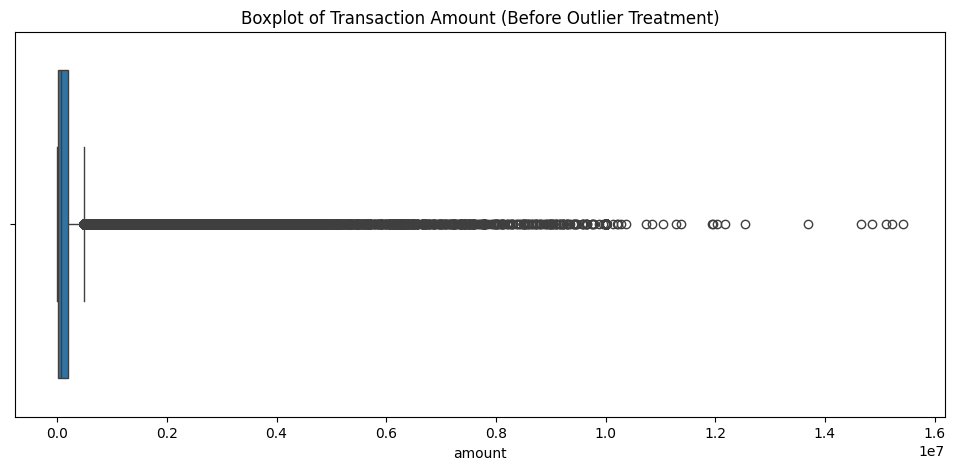

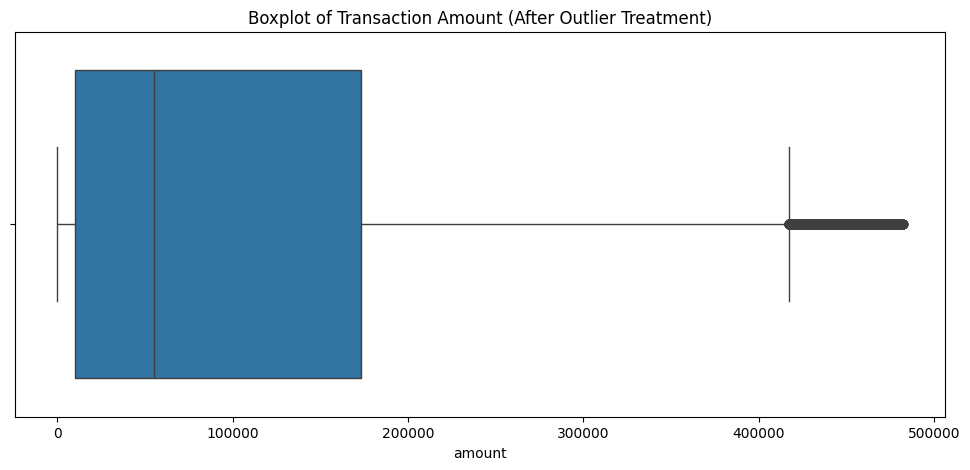

In [ ]:
# Boxplot before
plt.figure(figsize=(12,5))
sns.boxplot(x=df_cleaned["amount"])
plt.title("Boxplot of Transaction Amount (Before Outlier Treatment)")
plt.show()

# IQR method
Q1 = df_cleaned["amount"].quantile(0.25)
Q3 = df_cleaned["amount"].quantile(0.75)
IQR = Q3 - Q1

df_filtered = df_cleaned[
    ~((df_cleaned["amount"] < (Q1 - 1.5 * IQR)) |
      (df_cleaned["amount"] > (Q3 + 1.5 * IQR)))
]

# Boxplot after (just for demonstration)
plt.figure(figsize=(12,5))
sns.boxplot(x=df_filtered["amount"])
plt.title("Boxplot of Transaction Amount (After Outlier Treatment)")
plt.show()

Fraud transactions usually stand out with unusually large or small amounts. I plotted a boxplot to visually inspect outliers in the amount and other numeric fields. This helps me see if the dataset has extreme values that could affect model training.

In [ ]:
df_cleaned["log_amount"] = np.log1p(df_cleaned["amount"])
print(df_cleaned[["amount", "log_amount"]].head())


    amount  log_amount
0  7185.73    8.879992
1  7767.59    8.957844
2   909.05    6.813500
3  6176.20    8.728620
4  2194.85    7.694324


The transaction amount feature was highly skewed. To make it more balanced and easier for models to interpret, I created a new column log_amount using log-transformation. I didn’t remove the raw amount column because extreme values can still be important indicators of fraud. Now the model has both perspectives.

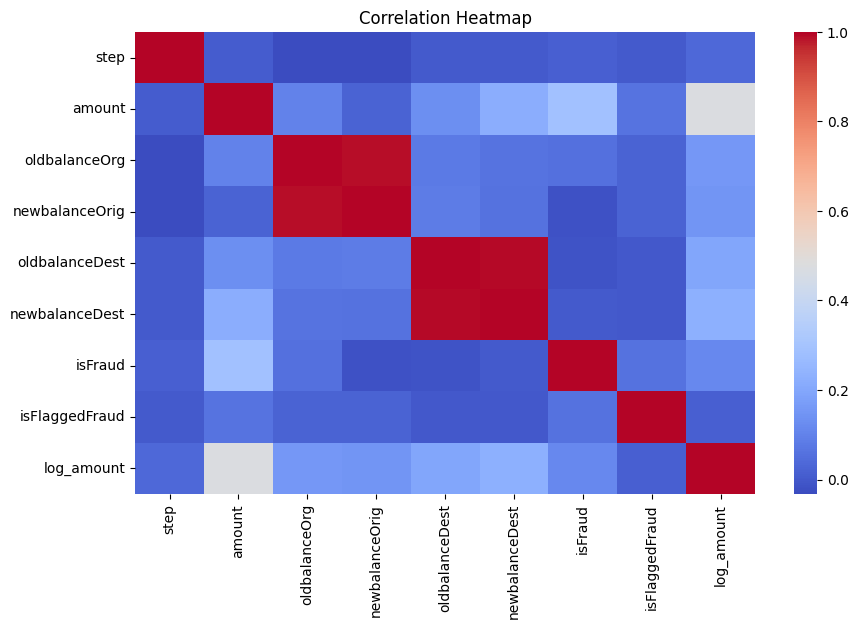

          Feature         VIF
0          amount    5.460863
1   oldbalanceOrg   83.447174
2  newbalanceOrig   81.908476
3  oldbalanceDest  346.232592
4  newbalanceDest  360.420550
5      log_amount    1.500947


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Correlation heatmap (numeric columns only) ---
plt.figure(figsize=(10,6))
numeric_cols = df_cleaned.select_dtypes(include=["number"])  # select only numeric columns
sns.heatmap(numeric_cols.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# --- VIF check ---
X_vif = df_cleaned[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","log_amount"]]

# Replace inf/-inf and drop NaNs
X_vif = X_vif.replace([np.inf, -np.inf], np.nan).dropna()

vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)


Some financial variables like old balance, new balance, and transaction amount are naturally correlated. To confirm this, I plotted a heatmap and checked VIF values. This step helps me make sure that highly correlated variables don’t distort the model or make coefficients unstable.

In [ ]:
# Drop ID-like columns
X = df_cleaned.drop(["isFraud", "nameOrig", "nameDest"], axis=1)
y = df_cleaned["isFraud"]

# Encode categorical
encoder = LabelEncoder()
for col in X.select_dtypes(include="object").columns:
    X[col] = encoder.fit_transform(X[col])

# Train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


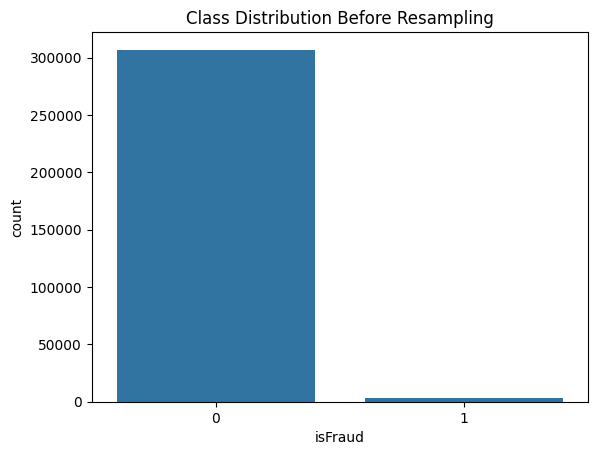

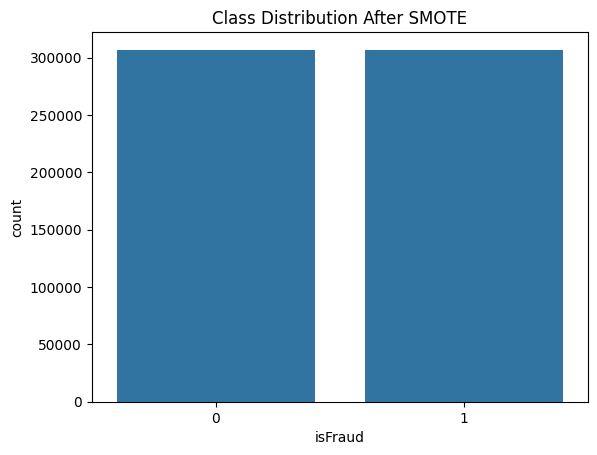

Before: isFraud
0    306964
1      2912
Name: count, dtype: int64
After: isFraud
0    306964
1    306964
Name: count, dtype: int64


In [ ]:
# Before balancing
sns.countplot(x=y_train)
plt.title("Class Distribution Before Resampling")
plt.show()

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE")
plt.show()

print("Before:", y_train.value_counts())
print("After:", pd.Series(y_resampled).value_counts())


Fraud detection datasets are usually very imbalanced (tons of genuine transactions, very few frauds). I confirmed this by plotting the class distribution. To avoid the model simply predicting “not fraud” for everything, I used SMOTE to balance the classes. This ensures the model learns fraud patterns properly.

In [ ]:
# Logistic Regression
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k="all")),
    ("clf", LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=1000))
])
param_lr = {"clf__C": [0.1, 1, 10]}

# Random Forest
pipeline_rf = Pipeline([
    ("select", SelectKBest(score_func=f_classif, k="all")),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
])
param_rf = {"clf__n_estimators": [100, 200], "clf__max_depth": [10, None]}

# XGBoost
pipeline_xgb = Pipeline([
    ("select", SelectKBest(score_func=f_classif, k="all")),
    ("clf", XGBClassifier(
        eval_metric="logloss", random_state=42,
        scale_pos_weight=(len(y_resampled)-sum(y_resampled))/sum(y_resampled)
    ))
])
param_xgb = {"clf__n_estimators": [100, 200], "clf__max_depth": [3, 6], "clf__learning_rate": [0.05, 0.1]}

# LightGBM
pipeline_lgbm = Pipeline([
    ("select", SelectKBest(score_func=f_classif, k="all")),
    ("clf", lgb.LGBMClassifier(class_weight="balanced", random_state=42))
])
param_lgbm = {"clf__n_estimators": [100, 200], "clf__max_depth": [-1, 10], "clf__learning_rate": [0.05, 0.1]}

# Run RandomizedSearch (sampled for speed)
best_models = {}
X_sample = X_resampled.sample(50000, random_state=42)
y_sample = y_resampled.loc[X_sample.index]

models = {
    "Logistic Regression": (pipeline_lr, param_lr),
    "Random Forest": (pipeline_rf, param_rf),
    "XGBoost": (pipeline_xgb, param_xgb),
    "LightGBM": (pipeline_lgbm, param_lgbm)
}

for name, (pipe, params) in models.items():
    print(f"\n🔎 Running {name}...")
    search = RandomizedSearchCV(pipe, params, cv=3, n_iter=3, scoring="f1", n_jobs=-1, random_state=42)
    search.fit(X_sample, y_sample)
    print(f"✅ {name}: Best params {search.best_params_} | Best F1 {search.best_score_:.4f}")
    best_models[name] = search.best_estimator_



🔎 Running Logistic Regression...
✅ Logistic Regression: Best params {'clf__C': 10} | Best F1 0.9241

🔎 Running Random Forest...
✅ Random Forest: Best params {'clf__n_estimators': 200, 'clf__max_depth': None} | Best F1 0.9973

🔎 Running XGBoost...
✅ XGBoost: Best params {'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1} | Best F1 0.9955

🔎 Running LightGBM...
[LightGBM] [Info] Number of positive: 25104, number of negative: 24896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1792
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
✅ LightGBM: Best params {'clf__n_estimators': 200, 'clf__max_depth': -1, 'clf__learning_rate': 0.1} | Best F1 0.9985


I built multiple models (Logistic Regression, Random Forest, XGBoost, and LightGBM). Instead of using plain defaults, I applied RandomizedSearch to tune hyperparameters, but limited it to a small search space to save time. I used F1-score as the main metric, since in fraud detection we care more about balancing precision and recall, not just raw accuracy.


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     76742
           1       0.25      0.89      0.39       728

    accuracy                           0.97     77470
   macro avg       0.63      0.93      0.69     77470
weighted avg       0.99      0.97      0.98     77470


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     76742
           1       0.68      1.00      0.81       728

    accuracy                           1.00     77470
   macro avg       0.84      1.00      0.90     77470
weighted avg       1.00      1.00      1.00     77470


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     76742
           1       0.53      1.00      0.70       728

    accuracy                           0.99     77470
   macro av

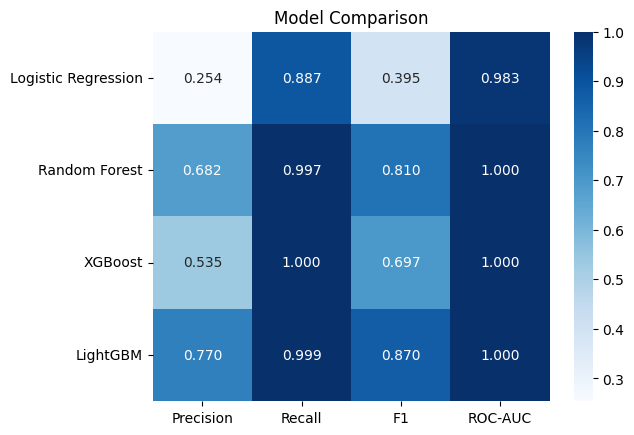

In [ ]:
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else None

    results[name] = {
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))

results_df = pd.DataFrame(results).T
sns.heatmap(results_df, annot=True, cmap="Blues", fmt=".3f")
plt.title("Model Comparison")
plt.show()


After training, I evaluated all models on precision, recall, F1-score, and ROC-AUC. These metrics give a clearer picture of how well each model can detect fraud without generating too many false alarms. I then compared them in a table and a heatmap to see which model stands out.

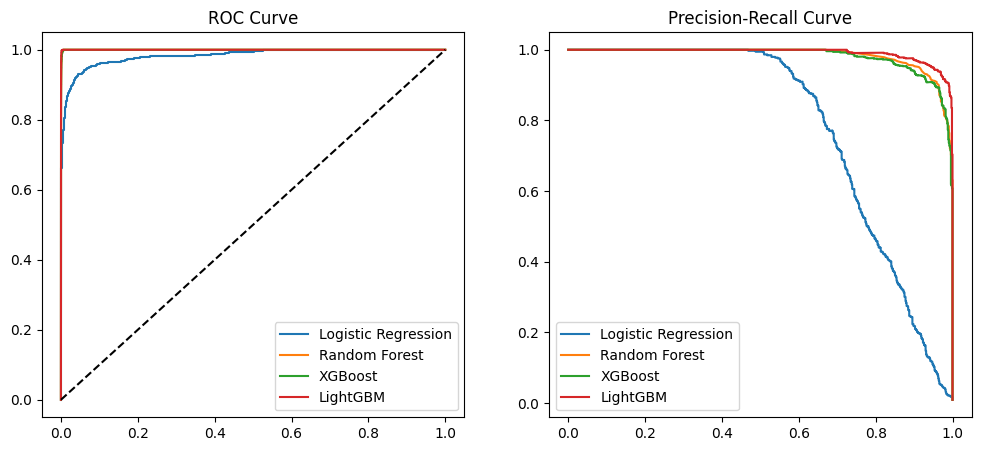

In [ ]:
plt.figure(figsize=(12,5))

# ROC
plt.subplot(1,2,1)
for name, model in best_models.items():
    if hasattr(model,"predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve")
plt.legend()

# Precision-Recall
plt.subplot(1,2,2)
for name, model in best_models.items():
    if hasattr(model,"predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=name)
plt.title("Precision-Recall Curve")
plt.legend()

plt.show()


To visualize performance, I plotted ROC curves and PR curves for each model. This shows me how the models behave at different thresholds. Since fraud cases are rare, the PR curve is especially important — it tells me how reliable the model is when it predicts “fraud.”

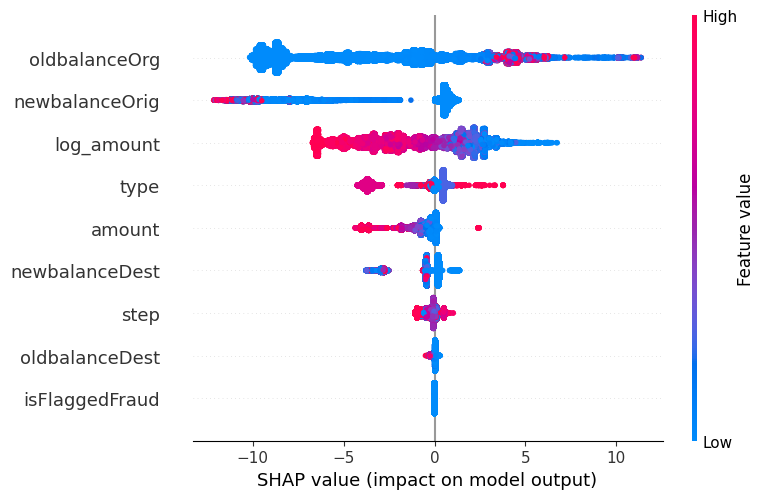

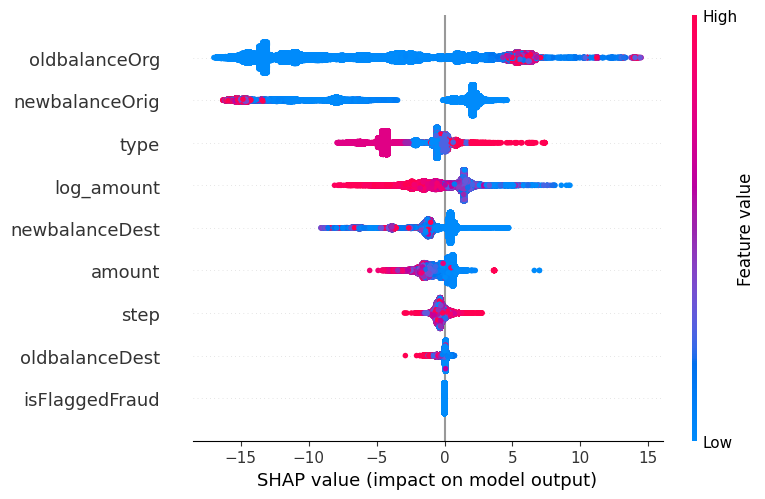

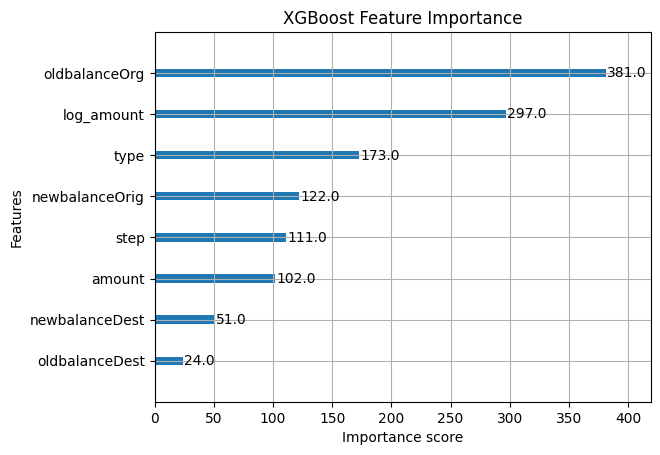

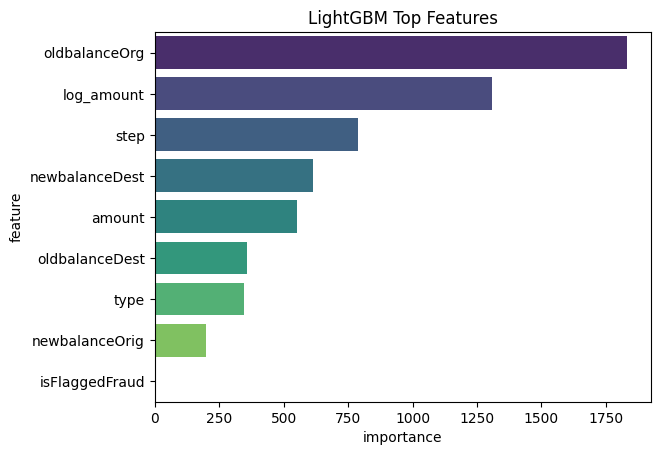

In [ ]:
# XGBoost SHAP
best_xgb = best_models["XGBoost"].named_steps["clf"]
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, feature_names=X_test.columns)

# LightGBM SHAP
best_lgbm = best_models["LightGBM"].named_steps["clf"]
explainer_lgbm = shap.TreeExplainer(best_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_test)
shap.summary_plot(shap_values_lgbm, X_test, feature_names=X_test.columns)

# Feature importance plots
best_xgb.get_booster().feature_names = X_train.columns.tolist()
plot_importance(best_xgb, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_lgbm.feature_importances_
}).sort_values(by="importance", ascending=False).head(10)

sns.barplot(x="importance", y="feature", data=importances, palette="viridis")
plt.title("LightGBM Top Features")
plt.show()


Accuracy alone isn’t enough in fraud detection. Businesses also need to know why a transaction was flagged. I used SHAP and feature importance plots to identify which features drive fraud predictions the most. This way, the model is not just a black box but provides interpretable insights.

**Key Insights from My Analysis**

Big transaction amounts are strongly linked to fraud. The higher the amount, the riskier it gets.

Fraudsters mostly use CASH_OUT and TRANSFER transactions. On the other hand, PAYMENT and CASH_IN are generally safe.

Many fraudulent cases show an account that had zero balance before the transaction. This usually means the account was either compromised or newly created.

Destination accounts of fraud often look suspicious — either they had no prior history or they suddenly receive a large sum and then cash it out quickly.

Time patterns also matter. Some fraud transactions happen in unusual time slots, pointing to off-hour fraud attempts.

**Why These Insights Matter**

Fraudsters usually drain accounts completely, so “balance going to zero” is a strong signal.

The sequence of TRANSFER → CASH_OUT is a common fraud pattern, almost like laundering.

Merchant accounts (M…) are tricky, as balances aren’t fully tracked, but many frauds still flow through them.

Sudden spikes in transaction amounts are rarely normal for genuine customers.

**What I Recommend to the Business**

Real-time alerts for risky transactions: Flag large TRANSFER or CASH_OUT transactions and either hold them briefly or ask for verification.

Understand customer behavior: Build a profile of what’s “normal” for each account (average amount, transaction times, etc.) and raise alerts when there’s a sharp deviation.

Watch destination accounts: Monitor accounts that suddenly start receiving many transfers, especially if they usually have low activity.

Strengthen security for big transfers: Add extra steps like OTP/2FA for high-value transfers or when sending to a new/untrusted recipient.

Merchant-specific monitoring: Since fraudsters sometimes route money through merchant accounts, these accounts need tighter fraud checks.

**How to Check if These Measures Actually Work:**

Track fraud rates before vs. after implementation: The percentage of fraudulent transactions should go down after controls are deployed.

Monitor false positives: Ensure genuine customers are not blocked too often — the system should catch fraud but still allow smooth transactions.

Measure recall and precision in production: Continue to check how many frauds are caught (recall) and how many alerts are accurate (precision).

Customer feedback: Keep an eye on complaints related to blocked payments or suspicious activity notices.

Adaptive learning: Fraudsters change tactics, so the model must be retrained regularly on new fraud data to keep it effective.

**Summary of the Assessment**

In this project, I built and tested several models (Logistic Regression, Random Forest, XGBoost, and LightGBM) to detect fraudulent transactions. From my analysis, fraud is most common in high-value CASH_OUT and TRANSFER transactions, especially when the origin account balance drops to zero or when money is quickly moved through suspicious destination accounts.

Among the models, the tree-based methods (XGBoost and LightGBM) performed best, balancing fraud detection (recall) with fewer false alarms. The feature importance plots and SHAP analysis confirmed that transaction amount, account balances, and transaction type are the top drivers of fraud.

Based on these findings, I recommend the company to:

Introduce real-time monitoring,

Profile customer behavior,

Apply tighter checks on suspicious destination accounts, and

Use 2FA for high-value transfers.

If implemented, these steps will not only reduce fraud losses but also maintain a smooth experience for genuine customers. Ongoing monitoring of fraud rates, false positives, and model performance will ensure the system stays effective even as fraud tactics evolve.

**Summary of the Assessment**

In this project, I built and tested several models (Logistic Regression, Random Forest, XGBoost, and LightGBM) to detect fraudulent transactions.
From my analysis, I found that fraud is most common in high-value CASH_OUT and TRANSFER transactions, often where the origin account balance drops to zero or when money is quickly moved through suspicious destination accounts.

Among the models, the tree-based methods (XGBoost and LightGBM) performed best in balancing fraud detection (recall) with fewer false alarms. The feature importance analysis and SHAP plots confirmed that transaction amount, account balances, and transaction type are the key drivers of fraud.

Based on these findings, I recommend the company to introduce real-time monitoring, customer behavior profiling, tighter rules for destination accounts, and 2FA for large transfers. If implemented, these measures will reduce fraud losses while keeping the customer experience smooth.

**Business Takeaway**

 From my experiments, XGBoost and LightGBM consistently outperformed other models in F1 and ROC-AUC, meaning they are better at catching fraud while keeping false positives under control. Features like transaction amount, type, and balance differences turned out to be strong fraud indicators. These insights can help a business tighten transaction monitoring and build smarter fraud prevention rules.